# Few Shot Sampling of Blood Smear Images

## Custom Dataloader

In [37]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [38]:
# from google.colab import drive
# drive.mount('/content/drive')

In [39]:

def resize_and_pad(image, target_size=(320, 320), fill=0):
    """
    Resize an image to fit within the target size while preserving the aspect ratio,
    then pad the shorter sides with a constant value to reach the target size.

    Args:
        image (PIL.Image): Input image.
        target_size (tuple): Target size (width, height), default (224, 224).
        fill (int or tuple): Padding fill value (e.g., 0 for black, 255 for white).

    Returns:
        PIL.Image: Resized and padded image of size target_size.
    """
    # Get original dimensions
    width, height = image.size
    target_width, target_height = target_size

    # Calculate scaling factor to fit within target size
    scale = min(target_width / width, target_height / height)
    new_width = int(width * scale)
    new_height = int(height * scale)

    # Resize image with correct (height, width) order
    resized_image = transforms.functional.resize(image, (new_height, new_width))

    # Calculate padding to center the image
    padding_left = (target_width - new_width) // 2
    padding_top = (target_height - new_height) // 2
    # Ensure padding adds up exactly to the difference
    padding_right = target_width - new_width - padding_left
    padding_bottom = target_height - new_height - padding_top

    # Apply padding
    padded_image = transforms.functional.pad(
        resized_image,
        padding=(padding_left, padding_top, padding_right, padding_bottom),
        fill=fill
    )

    return padded_image

In [40]:
# Basic Image transformation
def get_base_transforms(target_size=(320, 320), use_grayscale=False):
    """
    Returns a composed set of basic image transformations for preprocessing input images.

    Parameters:
    - target_size (tuple): The desired output size (height, width) of the image after resizing and padding.
    - use_grayscale (bool): If True, converts the image to grayscale with 3 channels before applying other transformations.

    Returns:
    - torchvision.transforms.Compose: A sequence of transformations including:
        - Optional grayscale conversion with 3 output channels,
        - Resizing and padding the image to match the target size,
        - Conversion to tensor,
        - Normalization using ImageNet mean and standard deviation.
    """
    base_transforms = [
        transforms.Lambda(lambda img: resize_and_pad(img, target_size=target_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]

    if use_grayscale:
        base_transforms.insert(0, transforms.Grayscale(num_output_channels=3))  # Keep 3 channels for compatibility
    return transforms.Compose(base_transforms)


# Data augmentation transforms
def get_augmentation_transforms():
    """
    Returns a composed set of data augmentation transformations to artificially expand the training dataset.

    This function applies a series of random transformations to simulate variations in brightness, contrast, orientation,
    and color mode, helping the model generalize better.

    Returns:
    - torchvision.transforms.Compose: A sequence of transformations including:
        - Random brightness and contrast adjustment (ColorJitter),
        - Random horizontal and vertical flipping,
        - Random rotation by up to ±10 degrees,
        - Random conversion to grayscale with a 20% probability.
    """
    return transforms.Compose([
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Simulate lighting/stain variations
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.RandomGrayscale(p=0.2)  # Optional: Randomly apply grayscale as part of augmentation
    ])


In [41]:
class FewShotDataset(Dataset):
    def __init__(self, data_dir, split, num_ways=5, num_support=5,
                 num_query=10, num_episodes=100, target_size=(320, 320),
                 use_grayscale=False,
                 augment=False,
                 ):
        """
        Args:
            data_dir (str): Path to dataset directory
            split (str): One of 'train', 'validation', or 'test'
            num_ways (int): Number of classes per episode
            num_support (int): Number of support samples per class (i.e. number of shots)
            num_query (int): Number of query samples per class
            num_episodes (int): Number of episodes per epoch
            use_grayscale(bool),  Use grayscale or not
            augment(bool),        For data augmentation technique
        """
        self.split_dir = os.path.join(data_dir, split)
        self.num_ways = num_ways
        self.num_support = num_support
        self.num_query = num_query
        self.num_episodes = num_episodes
        base_transform = get_base_transforms(target_size, use_grayscale)
        if augment:
            augmentation_transform = get_augmentation_transforms()
            self.transform = transforms.Compose([augmentation_transform, base_transform])
        else:
            self.transform = base_transform

        # Load class directories and their images
        self.classes = [c for c in os.listdir(self.split_dir)
                       if os.path.isdir(os.path.join(self.split_dir, c))]
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}  # Map class names to indices
        self.idx_to_class = {idx: cls for cls, idx in self.class_to_idx.items()}  # Map indices to class names
        self.class_images = {
            c: [os.path.join(self.split_dir, c, img)
                for img in os.listdir(os.path.join(self.split_dir, c))]
            for c in self.classes
        }

    def __len__(self):
        return self.num_episodes

    def __getitem__(self, index):
        # Randomly select N classes for this episode
        selected_classes = np.random.choice(self.classes, self.num_ways, replace=False)

        support_images = []
        support_labels = []
        query_images = []
        query_labels = []

        for label_idx, class_name in enumerate(selected_classes):
            all_images = self.class_images[class_name]
            if len(all_images) < self.num_support + self.num_query:
                raise ValueError(
                    f"Class {class_name} has only {len(all_images)} images. "
                    f"Need at least {self.num_support + self.num_query}."
                )

            # Randomly select support and query images
            selected_indices = np.random.choice(
                len(all_images),
                self.num_support + self.num_query,
                replace=False #True#########################################################################
            )
            support_paths = [all_images[i] for i in selected_indices[:self.num_support]]
            query_paths = [all_images[i] for i in selected_indices[self.num_support:]]

            # Load and transform support images
            for path in support_paths:
                img = Image.open(path).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                support_images.append(img)
                support_labels.append(label_idx)

            # Load and transform query images
            for path in query_paths:
                img = Image.open(path).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                query_images.append(img)
                query_labels.append(label_idx)

        # Shuffle the support and query sets
        support_indices = np.arange(len(support_images))
        query_indices = np.arange(len(query_images))
        np.random.shuffle(support_indices)
        np.random.shuffle(query_indices)

        support_images = [support_images[i] for i in support_indices]
        support_labels = [support_labels[i] for i in support_indices]
        query_images = [query_images[i] for i in query_indices]
        query_labels = [query_labels[i] for i in query_indices]

        # Convert lists to tensors
        support_set = (
            torch.stack(support_images),
            torch.tensor(support_labels, dtype=torch.long)
        )
        query_set = (
            torch.stack(query_images),
            torch.tensor(query_labels, dtype=torch.long)
        )
        # Store the selected class names for this episode
        selected_classes = [str(cls) for cls in selected_classes]
        episode_classes = selected_classes

        return support_set, query_set, episode_classes

In [42]:
def get_data_loader(dataset, batch_size=1, shuffle=True):
    """
    Returns DataLoader for the dataset.
    Note: Batch size should typically be 1 for few-shot learning,
    as each episode is a separate task.
    """
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=2,
        pin_memory=True
    )

## Modelling

### Optimization Based

In [43]:
%pip install higher --quiet

Note: you may need to restart the kernel to use updated packages.


In [44]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import higher
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy
import warnings

warnings.filterwarnings("ignore")

In [45]:
class MAMLResNet(nn.Module):
    def __init__(self, num_ways=5, pretrained=True):
        super().__init__()
        # Load pretrained ResNet50 and replace the final layer
        self.resnet = models.resnet50(pretrained=pretrained)

        # Unfreeze only the last few layers for fine-tuning
        for param in list(self.resnet.parameters())[:-10]:
            param.requires_grad = False

        # Replace the final fully connected layer
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_ways)

        # Initialize the final layer with appropriate weights
        nn.init.xavier_uniform_(self.resnet.fc.weight)
        nn.init.zeros_(self.resnet.fc.bias)

    def forward(self, x):
        return self.resnet(x)

In [46]:
def train_maml_epoch(
    model,
    train_loader,
    meta_optimizer,
    epoch,
    num_inner_steps=5,  # Increased inner steps for better adaptation
    inner_lr=0.01,
    device="cuda"
):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Use tqdm for progress tracking
    with tqdm(train_loader, desc=f'Epoch {epoch}') as pbar:
        for episode_idx, (support, query, classes) in enumerate(pbar):
            # Unpack data and remove batch dimension
            support_images, support_labels = support
            query_images, query_labels = query

            support_images = support_images.squeeze(0).to(device)
            support_labels = support_labels.squeeze(0).to(device)
            query_images = query_images.squeeze(0).to(device)
            query_labels = query_labels.squeeze(0).to(device)

            meta_optimizer.zero_grad()

            # Use higher library for differentiation through optimization
            with higher.innerloop_ctx(model, torch.optim.SGD(model.parameters(), lr=inner_lr),
                                     copy_initial_weights=True) as (fast_model, inner_optimizer):
                # Inner loop adaptation - multiple steps
                for _ in range(num_inner_steps):
                    support_outputs = fast_model(support_images)
                    support_loss = F.cross_entropy(support_outputs, support_labels)
                    inner_optimizer.step(support_loss)

                # Query loss calculation (meta-objective)
                query_outputs = fast_model(query_images)
                query_loss = F.cross_entropy(query_outputs, query_labels)

                # Calculate accuracy for monitoring
                _, predicted = torch.max(query_outputs.data, 1)
                correct += (predicted == query_labels).sum().item()
                total += query_labels.size(0)

                # Meta update
                query_loss.backward()

            # Apply meta-update to the original model
            meta_optimizer.step()

            # Update statistics
            total_loss += query_loss.item()

            # Update progress bar
            pbar.set_postfix({
                'loss': f'{total_loss/(episode_idx+1):.4f}',
                'acc': f'{100*correct/total:.2f}%'
            })

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configuration
num_ways = 5  # Number of classes per episode
num_shots = 5  # Number of support samples per class for training
num_epochs = 100  # Set to 50 as requested
num_episodes_per_epoch = 500
num_shots_test = [1, 5, 10]  # Different shot settings for testing

# Setup data directory
# data_dir = "/content/drive/MyDrive/Computer vision with few shot sampling focus group/data_set"
data_dir = "/home/ifihan/multi-dease-detection/data_set"

Using device: cuda


In [48]:
class MAMLResNet(nn.Module):
    def __init__(self, num_ways=5, pretrained=True):
        super().__init__()
        self.resnet = models.resnet50(pretrained=pretrained)
        for param in list(self.resnet.parameters())[:-10]:
            param.requires_grad = False
        self.resnet.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(self.resnet.fc.in_features, num_ways)
        )
        linear_layer = self.resnet.fc[1]
        nn.init.xavier_uniform_(linear_layer.weight)
        nn.init.zeros_(linear_layer.bias)

    def forward(self, x):
        return self.resnet(x)

def train_maml_epoch(
    model,
    train_loader,
    meta_optimizer,
    epoch,
    num_inner_steps=5,
    inner_lr=0.01,
    device="cuda"
):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    with tqdm(train_loader, desc=f'Epoch {epoch}') as pbar:
        for episode_idx, (support, query, classes) in enumerate(pbar):
            support_images, support_labels = support
            query_images, query_labels = query
            support_images = support_images.squeeze(0).to(device)
            support_labels = support_labels.squeeze(0).to(device)
            query_images = query_images.squeeze(0).to(device)
            query_labels = query_labels.squeeze(0).to(device)
            meta_optimizer.zero_grad()
            with higher.innerloop_ctx(model, torch.optim.SGD(model.parameters(), lr=inner_lr),
                                     copy_initial_weights=True) as (fast_model, inner_optimizer):
                for _ in range(num_inner_steps):
                    support_outputs = fast_model(support_images)
                    support_loss = F.cross_entropy(support_outputs, support_labels)
                    inner_optimizer.step(support_loss)
                query_outputs = fast_model(query_images)
                query_loss = F.cross_entropy(query_outputs, query_labels)
                _, predicted = torch.max(query_outputs.data, 1)
                correct += (predicted == query_labels).sum().item()
                total += query_labels.size(0)
                query_loss.backward()
            meta_optimizer.step()
            total_loss += query_loss.item()
            pbar.set_postfix({
                'loss': f'{total_loss/(episode_idx+1):.4f}',
                'acc': f'{100*correct/total:.2f}%'
            })
    epoch_loss = total_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_maml_epoch(
    model,
    val_loader,
    num_inner_steps=5,
    inner_lr=0.01,
    device="cuda"
):
    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_samples = 0
    
    for episode_idx, (support, query, classes) in enumerate(tqdm(val_loader, desc="Validation")):
        support_images, support_labels = support
        query_images, query_labels = query
        
        support_images = support_images.squeeze(0).to(device)
        support_labels = support_labels.squeeze(0).to(device)
        query_images = query_images.squeeze(0).to(device)
        query_labels = query_labels.squeeze(0).to(device)
        
        # Create a copy of the model for this episode and set to train mode for adaptation
        episode_model = copy.deepcopy(model)
        episode_model.train()
        
        # Create an optimizer for adaptation
        episode_optimizer = torch.optim.SGD(
            filter(lambda p: p.requires_grad, episode_model.parameters()),
            lr=inner_lr
        )
        
        # Inner loop adaptation
        for _ in range(num_inner_steps):
            episode_optimizer.zero_grad()
            support_outputs = episode_model(support_images)
            support_loss = F.cross_entropy(support_outputs, support_labels)
            support_loss.backward()
            episode_optimizer.step()
        
        # Evaluate on query set
        episode_model.eval()
        with torch.no_grad():
            query_outputs = episode_model(query_images)
            query_loss = F.cross_entropy(query_outputs, query_labels)
            total_val_loss += query_loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(query_outputs.data, 1)
            correct = (predicted == query_labels).sum().item()
            total_val_correct += correct
            total_val_samples += query_labels.size(0)
    
    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = 100 * total_val_correct / total_val_samples
    
    return avg_val_loss, val_acc

# def validate_maml_epoch(
#     model,
#     val_loader,
#     num_inner_steps=5,
#     inner_lr=0.01,
#     device="cuda"
# ):
#     model.eval()
#     total_val_loss = 0
#     total_val_correct = 0
#     total_val_samples = 0
#     with torch.no_grad():
#         for episode_idx, (support, query, classes) in enumerate(tqdm(val_loader, desc="Validation")):
#             support_images, support_labels = support
#             query_images, query_labels = query
#             support_images = support_images.squeeze(0).to(device)
#             support_labels = support_labels.squeeze(0).to(device)
#             query_images = query_images.squeeze(0).to(device)
#             query_labels = query_labels.squeeze(0).to(device)
#             with higher.innerloop_ctx(model, torch.optim.SGD(model.parameters(), lr=inner_lr),
#                                       copy_initial_weights=True, track_higher_grads=False) as (fast_model, inner_optimizer):
#                 fast_model.train()
#                 for _ in range(num_inner_steps):
#                     support_outputs = fast_model(support_images)
#                     support_loss = F.cross_entropy(support_outputs, support_labels)
#                     inner_optimizer.step(support_loss)
#                 fast_model.eval()
#                 query_outputs = fast_model(query_images)
#                 query_loss = F.cross_entropy(query_outputs, query_labels)
#                 total_val_loss += query_loss.item()
#                 _, predicted = torch.max(query_outputs.data, 1)
#                 total_val_correct += (predicted == query_labels).sum().item()
#                 total_val_samples += query_labels.size(0)
#     avg_val_loss = total_val_loss / len(val_loader)
#     val_acc = 100 * total_val_correct / total_val_samples
#     return avg_val_loss, val_acc

def test_maml(
    model,
    test_loader,
    num_inner_steps=10,
    inner_lr=0.01,
    device="cuda",
    shots=[1, 5, 10]
):
    results = {}
    test_dir = os.path.join(data_dir, "test")
    available_classes = [c for c in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, c))]
    actual_num_ways = min(num_ways, len(available_classes))
    if actual_num_ways < num_ways:
        print(f"Warning: Found only {len(available_classes)} classes in test set, using num_ways={actual_num_ways}.")
    for shot in shots:
        print(f"\nEvaluating {shot}-shot performance...")
        test_dataset = FewShotDataset(
            data_dir=data_dir,
            split="test",
            num_ways=actual_num_ways,
            num_support=shot,
            num_query=15,
            num_episodes=200,
            augment=False
        )
        shot_test_loader = get_data_loader(test_dataset, shuffle=False)
        model.eval()
        total_correct = 0
        total_samples = 0
        all_accuracies = []
        for episode_idx, (support, query, episode_classes) in enumerate(tqdm(shot_test_loader, desc=f"Testing {shot}-shot")):
            support_images, support_labels = support
            query_images, query_labels = query
            support_images = support_images.squeeze(0).to(device)
            support_labels = support_labels.squeeze(0).to(device)
            query_images = query_images.squeeze(0).to(device)
            query_labels = query_labels.squeeze(0).to(device)
            episode_model = copy.deepcopy(model)
            episode_model.train()
            episode_optimizer = torch.optim.SGD(
                filter(lambda p: p.requires_grad, episode_model.parameters()),
                lr=inner_lr
            )
            for _ in range(num_inner_steps):
                episode_optimizer.zero_grad()
                support_outputs = episode_model(support_images)
                support_loss = F.cross_entropy(support_outputs, support_labels)
                support_loss.backward()
                episode_optimizer.step()
            episode_model.eval()
            with torch.no_grad():
                query_outputs = episode_model(query_images)
                preds = query_outputs.argmax(dim=1)
                episode_correct = (preds == query_labels).sum().item()
                episode_accuracy = episode_correct / len(query_labels)
                all_accuracies.append(episode_accuracy)
                total_correct += episode_correct
                total_samples += len(query_labels)
        mean_accuracy = total_correct / total_samples
        std_accuracy = np.std(all_accuracies)
        ci95 = 1.96 * std_accuracy / np.sqrt(len(all_accuracies))
        results[shot] = {'accuracy': mean_accuracy, 'ci95': ci95}
        print(f"{shot}-shot Test Accuracy: {mean_accuracy*100:.2f}% ± {ci95*100:.2f}%")
    return results


In [49]:
model = MAMLResNet(num_ways=num_ways, pretrained=True).to(device)
meta_optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(meta_optimizer, 'min', patience=3, factor=0.1, verbose=True)

In [50]:
train_dataset = FewShotDataset(
    data_dir=data_dir,
    split="train",
    num_ways=num_ways,
    num_support=num_shots,
    num_query=15,
    num_episodes=num_episodes_per_epoch,
    augment=True
)
train_loader = get_data_loader(train_dataset)

val_dataset = FewShotDataset(
    data_dir=data_dir,
    split="test",
    num_ways=min(5, len(os.listdir(os.path.join(data_dir, "test")))),
    num_support=num_shots,
    num_query=15,
    num_episodes=300,
    augment=False
)
val_loader = get_data_loader(val_dataset)


In [51]:
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
early_stop_counter = 0
patience = 10

# best_model_path = "/content/drive/MyDrive/Computer vision with few shot sampling focus group/"+f'maml_resnet50_{num_ways}way_{num_shots}shot_best.pth'
best_model_path = f"/home/ifihan/multi-dease-detection/best_model/maml_resnet50_{num_ways}way_{num_shots}shot_best.pth"


Epoch 1/100


Epoch 1: 100%|██████████| 500/500 [10:50<00:00,  1.30s/it, loss=1.7420, acc=27.25%]


Training - Loss: 1.7420, Accuracy: 27.25%, Time: 650.84s


Validation: 100%|██████████| 300/300 [02:05<00:00,  2.39it/s]


Validation - Loss: 1.4225, Accuracy: 33.15%
Saved new best model with validation accuracy: 33.15%

Epoch 2/100


Epoch 2: 100%|██████████| 500/500 [10:37<00:00,  1.28s/it, loss=1.7398, acc=27.66%]


Training - Loss: 1.7398, Accuracy: 27.66%, Time: 637.93s


Validation: 100%|██████████| 300/300 [02:03<00:00,  2.43it/s]


Validation - Loss: 1.4120, Accuracy: 34.60%
Saved new best model with validation accuracy: 34.60%

Epoch 3/100


Epoch 3: 100%|██████████| 500/500 [10:57<00:00,  1.32s/it, loss=1.7394, acc=27.31%]


Training - Loss: 1.7394, Accuracy: 27.31%, Time: 657.80s


Validation: 100%|██████████| 300/300 [02:04<00:00,  2.42it/s]


Validation - Loss: 1.4112, Accuracy: 34.31%

Epoch 4/100


Epoch 4: 100%|██████████| 500/500 [10:48<00:00,  1.30s/it, loss=1.7431, acc=27.33%]


Training - Loss: 1.7431, Accuracy: 27.33%, Time: 648.92s


Validation: 100%|██████████| 300/300 [02:05<00:00,  2.40it/s]


Validation - Loss: 1.4186, Accuracy: 34.08%

Epoch 5/100


Epoch 5: 100%|██████████| 500/500 [10:53<00:00,  1.31s/it, loss=1.7256, acc=27.68%]


Training - Loss: 1.7256, Accuracy: 27.68%, Time: 653.99s


Validation: 100%|██████████| 300/300 [02:03<00:00,  2.43it/s]


Validation - Loss: 1.4148, Accuracy: 33.62%

Epoch 6/100


Epoch 6: 100%|██████████| 500/500 [10:52<00:00,  1.31s/it, loss=1.7390, acc=27.50%]


Training - Loss: 1.7390, Accuracy: 27.50%, Time: 652.61s


Validation: 100%|██████████| 300/300 [02:03<00:00,  2.43it/s]


Validation - Loss: 1.4135, Accuracy: 34.48%

Epoch 7/100


Epoch 7: 100%|██████████| 500/500 [10:50<00:00,  1.30s/it, loss=1.7455, acc=27.34%]


Training - Loss: 1.7455, Accuracy: 27.34%, Time: 650.10s


Validation: 100%|██████████| 300/300 [02:04<00:00,  2.41it/s]


Validation - Loss: 1.4212, Accuracy: 33.68%

Epoch 8/100


Epoch 8: 100%|██████████| 500/500 [10:50<00:00,  1.30s/it, loss=1.7398, acc=27.52%]


Training - Loss: 1.7398, Accuracy: 27.52%, Time: 650.84s


Validation: 100%|██████████| 300/300 [02:03<00:00,  2.42it/s]


Validation - Loss: 1.4198, Accuracy: 34.12%

Epoch 9/100


Epoch 9: 100%|██████████| 500/500 [10:56<00:00,  1.31s/it, loss=1.7395, acc=27.26%]


Training - Loss: 1.7395, Accuracy: 27.26%, Time: 656.55s


Validation: 100%|██████████| 300/300 [02:04<00:00,  2.41it/s]


Validation - Loss: 1.4134, Accuracy: 34.15%

Epoch 10/100


Epoch 10: 100%|██████████| 500/500 [10:44<00:00,  1.29s/it, loss=1.7384, acc=27.55%]


Training - Loss: 1.7384, Accuracy: 27.55%, Time: 644.80s


Validation: 100%|██████████| 300/300 [02:03<00:00,  2.42it/s]


Validation - Loss: 1.4186, Accuracy: 33.96%
Saved checkpoint at epoch 10

Epoch 11/100


Epoch 11: 100%|██████████| 500/500 [10:56<00:00,  1.31s/it, loss=1.7366, acc=27.25%]


Training - Loss: 1.7366, Accuracy: 27.25%, Time: 656.97s


Validation: 100%|██████████| 300/300 [02:04<00:00,  2.42it/s]


Validation - Loss: 1.4132, Accuracy: 34.16%

Epoch 12/100


Epoch 12: 100%|██████████| 500/500 [10:58<00:00,  1.32s/it, loss=1.7342, acc=27.85%]


Training - Loss: 1.7342, Accuracy: 27.85%, Time: 658.21s


Validation: 100%|██████████| 300/300 [02:04<00:00,  2.42it/s]


Validation - Loss: 1.4225, Accuracy: 33.92%
Early stopping triggered


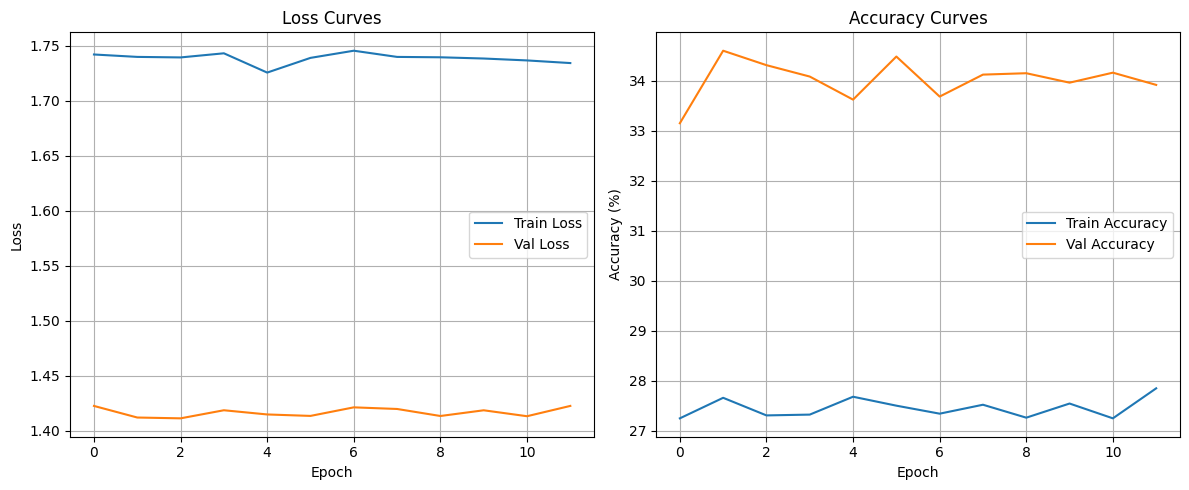

In [52]:
for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")
    start_time = time.time()
    train_loss, train_acc = train_maml_epoch(
        model=model,
        train_loader=train_loader,
        meta_optimizer=meta_optimizer,
        epoch=epoch,
        num_inner_steps=5,
        inner_lr=0.01,
        device=device
    )
    epoch_time = time.time() - start_time
    print(f"Training - Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%, Time: {epoch_time:.2f}s")

    val_loss, val_acc = validate_maml_epoch(
        model=model,
        val_loader=val_loader,
        num_inner_steps=5,
        inner_lr=0.01,
        device=device
    )
    print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    scheduler.step(val_loss)

    # if val_acc > best_val_acc:
    #     best_val_acc = val_acc
    #     torch.save({
    #         'epoch': epoch,
    #         'model_state_dict': model.state_dict(),
    #         'optimizer_state_dict': meta_optimizer.state_dict(),
    #         'val_accuracy': val_acc,
    #     }, best_model_path)
    #     print(f"Saved new best model with validation accuracy: {val_acc:.2f}%")
    #     early_stop_counter = 0

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        # Make sure the directory exists
        os.makedirs(os.path.dirname(best_model_path), exist_ok=True)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': meta_optimizer.state_dict(),
            'val_accuracy': val_acc,
        }, best_model_path)
        print(f"Saved new best model with validation accuracy: {val_acc:.2f}%")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

    if epoch % 10 == 0:
        checkpoint_path = f'maml_resnet50_{num_ways}way_{num_shots}shot_epoch{epoch}.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': meta_optimizer.state_dict(),
            'train_loss': train_loss,
            'train_accuracy': train_acc,
            'history': history,
        }, checkpoint_path)
        print(f"Saved checkpoint at epoch {epoch}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('maml_training_curves.png')
plt.show()

In [53]:
best_model_path = "/home/ifihan/multi-dease-detection/best_model/maml_resnet50_5way_5shot_best.pth"

In [54]:
def test_maml(
    model,
    test_loader,
    num_inner_steps=10,
    inner_lr=0.01,
    device="cuda",
    shots=[1, 5, 10]
):
    """
    Test the MAML model with different shot settings.
    Fixes the class count issue and gradient calculation issue.
    """
    # Dictionary to store results for each shot setting
    results = {}

    # Check the number of classes in the test directory
    test_dir = os.path.join(data_dir, "test")
    available_classes = [c for c in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, c))]
    actual_num_ways = min(num_ways, len(available_classes))

    if actual_num_ways < num_ways:
        print(f"Warning: Found only {len(available_classes)} classes in test set, but num_ways={num_ways}.")
        print(f"Will use num_ways={actual_num_ways} for testing.")

    for shot in shots:
        print(f"\nEvaluating {shot}-shot performance...")

        # Create test dataset for this shot setting
        test_dataset = FewShotDataset(
            data_dir=data_dir,
            split="test",
            num_ways=actual_num_ways,  # Use adjusted num_ways
            num_support=shot,
            num_query=15,
            num_episodes=300,
            augment=False
        )

        shot_test_loader = get_data_loader(test_dataset, shuffle=False)

        # Evaluate with this loader
        model.eval()
        total_correct = 0
        total_samples = 0
        all_accuracies = []

        for episode_idx, (support, query, episode_classes) in enumerate(tqdm(shot_test_loader, desc=f"Testing {shot}-shot")):
            support_images, support_labels = support
            query_images, query_labels = query

            support_images = support_images.squeeze(0).to(device)
            support_labels = support_labels.squeeze(0).to(device)
            query_images = query_images.squeeze(0).to(device)
            query_labels = query_labels.squeeze(0).to(device)

            # Create a copy of the model for this episode
            episode_model = copy.deepcopy(model)

            # Make sure we enable gradient calculation for adaptation
            episode_model.train()
            for param in episode_model.parameters():
                param.requires_grad = True

            episode_optimizer = torch.optim.SGD(
                filter(lambda p: p.requires_grad, episode_model.parameters()),
                lr=inner_lr
            )

            # Inner loop adaptation
            for _ in range(num_inner_steps):
                # Zero gradients first
                episode_optimizer.zero_grad()

                # Forward pass
                support_outputs = episode_model(support_images)
                support_loss = F.cross_entropy(support_outputs, support_labels)

                # Backward pass
                support_loss.backward()

                # Step optimizer
                episode_optimizer.step()

            # Evaluation on query set
            episode_model.eval()
            with torch.no_grad():
                query_outputs = episode_model(query_images)
                preds = query_outputs.argmax(dim=1)
                episode_correct = (preds == query_labels).sum().item()
                episode_accuracy = episode_correct / len(query_labels)
                all_accuracies.append(episode_accuracy)

                total_correct += episode_correct
                total_samples += len(query_labels)

        # Calculate overall accuracy and confidence interval
        mean_accuracy = total_correct / total_samples
        std_accuracy = np.std(all_accuracies)
        ci95 = 1.96 * std_accuracy / np.sqrt(len(all_accuracies))

        # Store results
        results[shot] = {
            'accuracy': mean_accuracy,
            'ci95': ci95
        }

        print(f"{shot}-shot Test Accuracy: {mean_accuracy*100:.2f}% ± {ci95*100:.2f}%")

    return results

In [55]:
# Fix just the test_maml function call
best_model_path = "/home/ifihan/multi-dease-detection/best_model/maml_resnet50_5way_5shot_best.pth"

# Load the best model
print("\nLoading best model for final evaluation...")
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])

# Test with different shot settings
test_results = test_maml(
    model=model,
    test_loader=None,  # Not used as we create loaders inside the function
    num_inner_steps=10,
    inner_lr=0.01,
    device=device,
    shots=num_shots_test
)


Loading best model for final evaluation...
Will use num_ways=4 for testing.

Evaluating 1-shot performance...


Testing 1-shot:  41%|████      | 123/300 [00:49<01:11,  2.47it/s]

Testing 1-shot: 100%|██████████| 300/300 [01:57<00:00,  2.56it/s]


1-shot Test Accuracy: 32.48% ± 0.80%

Evaluating 5-shot performance...


Testing 5-shot: 100%|██████████| 300/300 [03:39<00:00,  1.37it/s]


5-shot Test Accuracy: 45.35% ± 0.84%

Evaluating 10-shot performance...


Testing 10-shot: 100%|██████████| 300/300 [05:42<00:00,  1.14s/it]

10-shot Test Accuracy: 51.58% ± 0.82%
